In [1]:
# Boilerplate imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define some default parameters for a realistic scenario
# Feel free to play with these parameters
nmeasurements = 144 # The number of experimental measurements
sigma_true = 1.5 # stddev of normal distribution from which true data is generated (arbitrary units)
rmse_true = 1.0 # true RMSE of computation compared to experiment (arbitrary units)
mue_true = rmse_true * np.sqrt(2/np.pi) # Note that the true MUE = RMSE * sqrt(2/pi) in this model
sigma_exp = 0.5 # stddev of random error added onto experiments due to experimental error sources (arbitrary units)
sigma_calc = 0.3 # stddev of random error added onto true computed value due to finite sample sizes (arbitrary units)

In [3]:
# Define a function to generate an experimental dataset from a background distribution
# along with true calculated values and observed experimental and calculated estimates
def generate_dataset(nmeasurements, sigma_true, rmse_true, sigma_exp, sigma_calc):
    """
    Generate an experimental dataset (and corresponding true values) by drawing from the true distribution of data.
    
    A set of `nmeasurements` true data values is generated from
    
    x_true[n] ~ N(0, sigma_true^2)   n = 1..nmeasurements
    
    from which experimental and calculated values are computed as
    
    x_exp[n] ~ N(x_true[n], sigma_exp^2)
    x_calc_true[n] ~ N(xtrue[n], rmse_true^2)
    x_calc[n] ~ N(xcalctrue[n], sigma_calc^2)    
    
    Note that the true MUE = RMSE * sqrt(2/pi) in this model.
    
    Parameters
    ----------
    nmeasurements : int
        The number of experimental measurements
    sigma_true : float
        stddev of normal distribution from which true data is generated
    rmse_true : float
        true RMSE of computation compared to experiment
    sigma_exp : float
        stddev of random error added onto experiments due to experimental error sources
    sigma_calc : float
        stddev of random error added onto true computed value due to finite sample sizes
        
    Returns
    -------
    x_true : float array of size [nmeasurements]
        True data values        
    x_calc_true : float array of size [nmeasurements]
        True calculated data values
    x_exp : float array of size [nmeasurements]
        Experimental measurements corrupted with noise
    x_calc : float array of size [nmeasurements]
        Calculated values corrupted with noise
    
    """
    x_true = sigma_true * np.random.randn(nmeasurements)
    x_calc_true = x_true + rmse_true * np.random.randn(nmeasurements)
    x_exp = x_true + sigma_exp * np.random.randn(nmeasurements)
    x_calc = x_calc_true + sigma_calc * np.random.randn(nmeasurements)

    return [x_true, x_calc_true, x_exp, x_calc]

In [4]:
# Define some sample statistics we're interested in
def mue(x, y):
    return np.mean(abs(x - y))

def rmse(x, y):
    return np.sqrt(np.mean((x - y)**2))    

First, let's geneate some example datasets and compile the distribution of observed sample statistics and true statistics to compare them. As expected, we'll find that the true RMSE and MUE distributions are smaller than the observed RMSE and MUE distributions once we've added measurement or statistical noise.

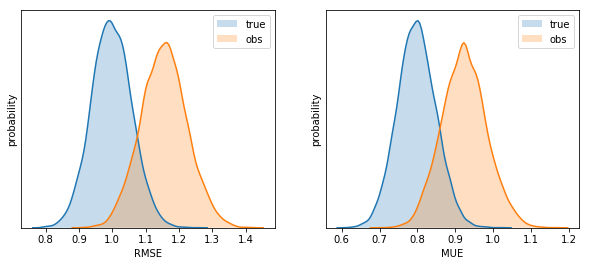

In [5]:
# Generate some datasets and compile statistics
nreplicates = 10000
rmse_true_n = np.zeros([nreplicates])
rmse_obs_n = np.zeros([nreplicates])
mue_true_n = np.zeros([nreplicates])
mue_obs_n = np.zeros([nreplicates])
for replicate in range(nreplicates):
    x_true, x_calc_true, x_exp, x_calc = generate_dataset(nmeasurements, sigma_true, rmse_true, sigma_exp, sigma_calc)
    mue_true_n[replicate] = mue(x_true, x_calc_true)
    mue_obs_n[replicate] = mue(x_exp, x_calc)
    rmse_true_n[replicate] = rmse(x_true, x_calc_true)
    rmse_obs_n[replicate] = rmse(x_exp, x_calc)

# Plot
plt.figure(figsize=[10,4]);

# RMSE
plt.subplot(121);
sns.kdeplot(rmse_true_n, shade=True);
sns.kdeplot(rmse_obs_n, shade=True);
plt.legend(['true', 'obs']);
plt.xlabel('RMSE');
plt.ylabel('probability');
plt.yticks([]);

# MUE
plt.subplot(122);
sns.kdeplot(mue_true_n, shade=True);
sns.kdeplot(mue_obs_n, shade=True);
plt.legend(['true', 'obs']);
plt.xlabel('MUE');
plt.ylabel('probability');
plt.yticks([]);


In [6]:
# Now, we introduce a Bayesian bootstrap sampling procedure in which we first just try to estimate the true 
# sample statistics (RMSE and MUE) by sampling from the Bayesian posteriors for x_true and x_calc_true 
# using a uniform prior and Normal error model with good estimates of the true stddev parameters.
# We don't yet try to estimate the true global RMSE and MUE as we aren't also bootstrapping over measurements.
def bootstrap_error(x_true, x_calc_true, x_exp, x_calc, sigma_exp, sigma_calc, nbootstrap=10000):
    """
    Define a bootstrap procedure to analyze a single experimental dataset by just adding experimental noise
    but not bootstrapping over data to see if we can estimate the true sample RMSE and MUE (but not global RMSE and MUE).
    
    Parameters
    ----------
    x_true : float array of size [nmeasurements]
        True data values        
    x_calc_true : float array of size [nmeasurements]
        True calculated data values
    x_exp : float array of size [nmeasurements]
        Experimental measurements corrupted with noise
    x_calc : float array of size [nmeasurements]
        Calculated values corrupted with noise
    sigma_exp : float
        stddev of random error added onto experiments due to experimental error sources
    sigma_calc : float
        stddev of random error added onto true computed value due to finite sample sizes
        
    """
    mue_bootstrap_n = np.zeros([nbootstrap])
    rmse_bootstrap_n = np.zeros([nbootstrap])
    for replicate in range(nbootstrap):
        # Sample from Bayesian posteriors
        x_exp_bootstrap = x_exp + sigma_exp * np.random.randn(nmeasurements)
        x_calc_bootstrap = x_calc + sigma_calc * np.random.randn(nmeasurements)
        # Store sample statistics
        mue_bootstrap_n[replicate] = mue(x_exp_bootstrap, x_calc_bootstrap)
        rmse_bootstrap_n[replicate] = rmse(x_exp_bootstrap, x_calc_bootstrap)

    true_sample_rmse = rmse(x_true, x_calc_true)
    true_sample_mue = mue(x_true, x_calc_true)
    
    # Plot
    plt.figure(figsize=[10,4]);

    # RMSE
    plt.subplot(121);
    sns.kdeplot(rmse_bootstrap_n, shade=True);
    plt.plot([true_sample_rmse, true_sample_rmse], [0, 10], 'k-');
    plt.legend(['true sample', 'bootstrap']);
    plt.xlabel('RMSE');
    plt.ylabel('probability');
    plt.yticks([]);

    # MUE
    plt.subplot(122);
    sns.kdeplot(mue_bootstrap_n, shade=True);
    plt.plot([true_sample_mue, true_sample_mue], [0, 10], 'k-');
    plt.legend(['true sample', 'bootstrap']);
    plt.xlabel('MUE');
    plt.ylabel('probability');
    plt.yticks([]);   

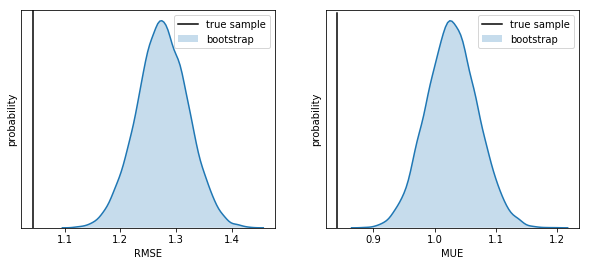

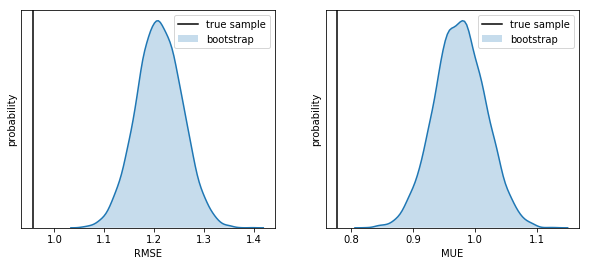

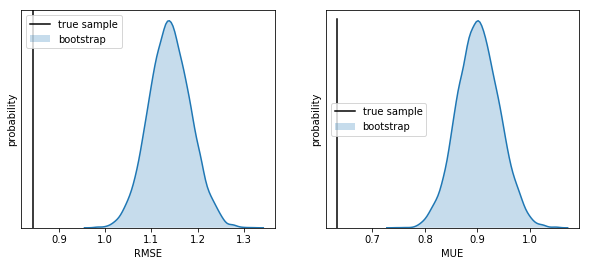

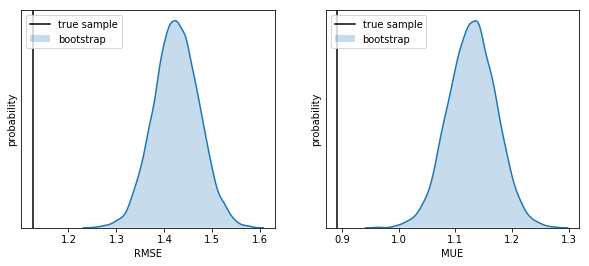

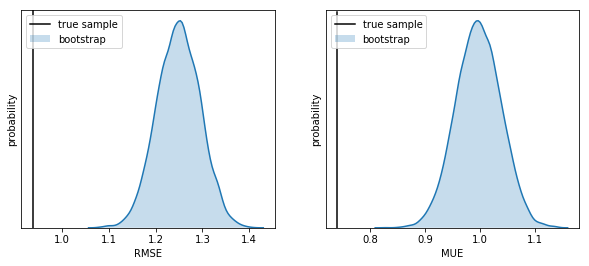

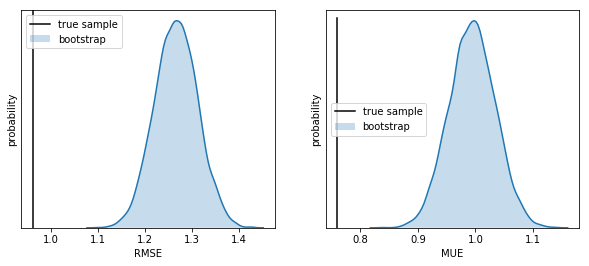

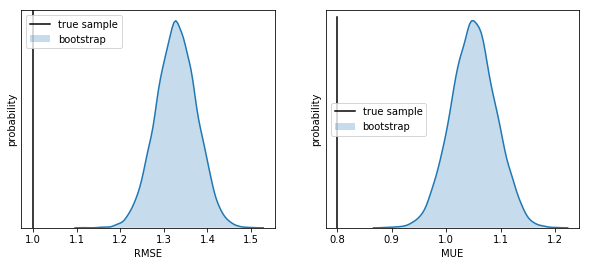

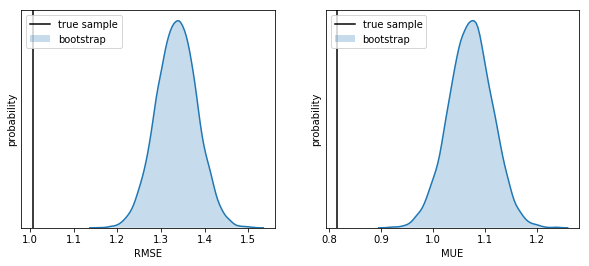

In [7]:
# Let's just simulate a few replicates of making some measurements and trying to bootstrap our posterior confidence
# distribution for MUE and RMSE to try to see if we reasonably capture the true underlying sample statistic.
for example in range(8):
    x_true, x_calc_true, x_exp, x_calc = generate_dataset(nmeasurements, sigma_true, rmse_true, sigma_exp, sigma_calc)
    bootstrap_error(x_true, x_calc_true, x_exp, x_calc, sigma_exp, sigma_calc)

This looks pretty good! If anything, it looks like the bootstrap sometimes underestimates the true sample statistic more often than it overestimates, but that may be a function of the particular assay parameters. A better way to do this is to check how often we overestimate or underestimate this by various degrees and generate what is called a Q-Q plot. We'll do that for the full Bayesian bootstrap model below.

In [8]:
# Now we also add bootstrapping over samples to get an idea of the true global RMSE and MUE.
def bootstrap_error_and_sample(x_true, x_calc_true, x_exp, x_calc, sigma_exp, sigma_calc, sigma_true, rmse_true, nbootstrap=10000):
    """
    Define a bootstrap procedure to analyze a single experimental dataset by both bootstrapping over measurements
    and adding experimental noise to see if we can estimate the global sample RMSE and MUE.
    
    Parameters
    ----------
    x_true : float array of size [nmeasurements]
        True data values        
    x_calc_true : float array of size [nmeasurements]
        True calculated data values
    x_exp : float array of size [nmeasurements]
        Experimental measurements corrupted with noise
    x_calc : float array of size [nmeasurements]
        Calculated values corrupted with noise
    sigma_exp : float
        stddev of random error added onto experiments due to experimental error sources
    sigma_calc : float
        stddev of random error added onto true computed value due to finite sample sizes
    sigma_true : float
        stddev of normal distribution from which true data is generated
    rmse_true : float
        true RMSE of computation compared to experiment        
        
    """
    mue_bootstrap_n = np.zeros([nbootstrap])
    rmse_bootstrap_n = np.zeros([nbootstrap])
    for replicate in range(nbootstrap):
        # Bootstrap measurements with replacement
        indices = np.random.choice(range(nmeasurements), size=nmeasurements)
        # Sample from Bayesian posteriors
        x_exp_bootstrap = x_exp[indices] + sigma_exp * np.random.randn(nmeasurements)
        x_calc_bootstrap = x_calc[indices] + sigma_calc * np.random.randn(nmeasurements)
        # Store sample statistics
        mue_bootstrap_n[replicate] = mue(x_exp_bootstrap, x_calc_bootstrap)
        rmse_bootstrap_n[replicate] = rmse(x_exp_bootstrap, x_calc_bootstrap)
        
    # Estimate the true MUE via a very large sample
    x = sigma_true * np.random.randn(10000)
    y = x + rmse_true * np.random.randn(10000)
    mue_true = mue(x, y)
    
    # Plot
    plt.figure(figsize=[10,4]);

    # RMSE
    plt.subplot(121);
    sns.kdeplot(rmse_bootstrap_n, shade=True);
    plt.plot([rmse_true, rmse_true], [0, 10], 'k-');
    plt.legend(['true global', 'bootstrap']);
    plt.xlabel('RMSE');
    plt.ylabel('probability');
    plt.yticks([]);

    # MUE
    plt.subplot(122);
    sns.kdeplot(mue_bootstrap_n, shade=True);
    plt.plot([mue_true, mue_true], [0, 10], 'k-');
    plt.legend(['true global', 'bootstrap']);
    plt.xlabel('MUE');
    plt.ylabel('probability');
    plt.yticks([]);   
    
    return rmse_bootstrap_n, mue_bootstrap_n

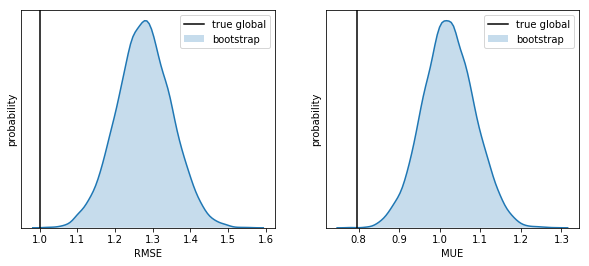

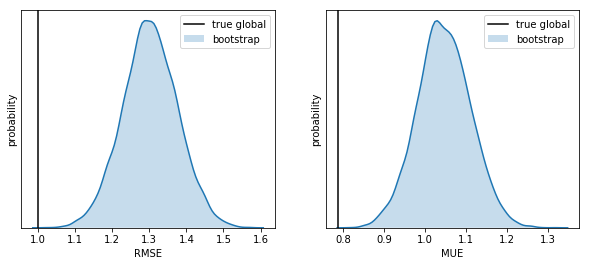

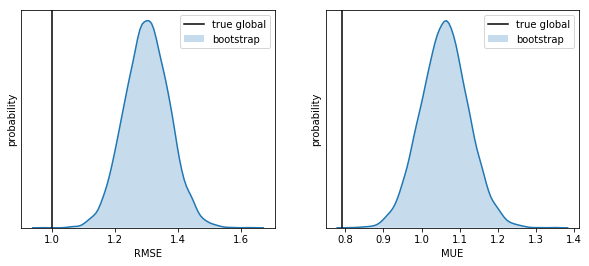

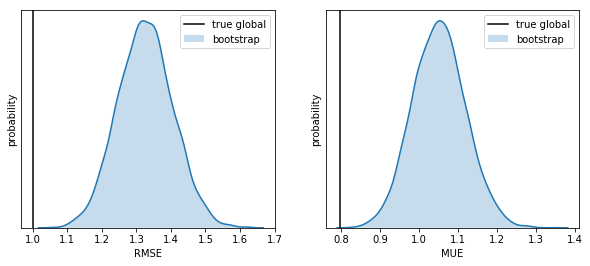

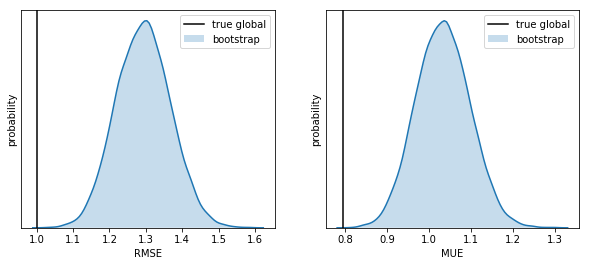

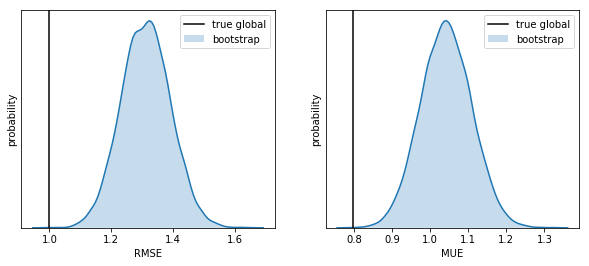

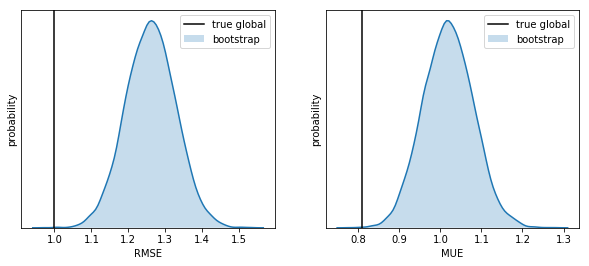

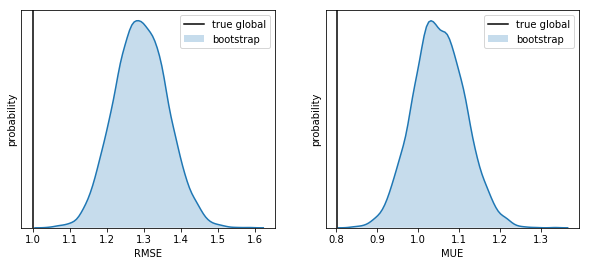

In [9]:
# Now let's run a few experiments and see how well we do
for example in range(8):
    x_true, x_calc_true, x_exp, x_calc = generate_dataset(nmeasurements, sigma_true, rmse_true, sigma_exp, sigma_calc)
    bootstrap_error_and_sample(x_true, x_calc_true, x_exp, x_calc, sigma_exp, sigma_calc, sigma_true, rmse_true)

The bootstrap procedure does indeed overestimate the global statistics if we simply evaluate the sample statistics on the bootstrap samples!

# The solution: Bayesian inference of global RMSE

The solution is to use a Bayesian hierarchical model where we make mild assumptions about how the error propagates into observations and then infer the distribution of the underlying calculation error (rmse_true) from the data.

We use pymc3 to make this simple and quick:
http://docs.pymc.io/

In [10]:
import pymc3 as pm
from scipy import optimize

In [11]:
# Draw some samples
x_true, x_calc_true, x_exp, x_calc = generate_dataset(nmeasurements, sigma_true, rmse_true, sigma_exp, sigma_calc)

In [12]:
# Define a pymc3 model

# For now, we assume we know the background distribution parameters for x_true and the stddevs for experimental
# error and calculation statistical error, but we can add those as nuisance parameters later.

basic_model = pm.Model()

with basic_model:
    # Priors    
    rv_rmse_true = pm.HalfFlat('rmse_true') # uninformative prior for nonnegative values
    rv_mue_true = pm.Deterministic('mue_true', rv_rmse_true*np.sqrt(2.0/np.pi)) # store MUE estimate alongside RMSE
    
    # Unknown true values and true computed values
    rv_true = pm.Normal('x_true', mu=0, sd=sigma_true, shape=nmeasurements)
    rv_calc_true = pm.Normal('x_calc_true', mu=rv_true, sd=rv_rmse_true, shape=nmeasurements)    
    
    # Observation models
    rv_calc = pm.Normal('x_calc', mu=rv_calc_true, sd=sigma_calc, shape=nmeasurements, observed=x_calc)
    rv_exp = pm.Normal('x_exp', mu=rv_true, sd=sigma_exp, shape=nmeasurements, observed=x_exp)

In [13]:
# Find the MAP estimate as a starting point for sampling
map_estimate = pm.find_MAP(model=basic_model)
map_estimate['rmse_true']

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
logp = 2,041.9, ||grad|| = 1.9566e+09: 100%|██████████| 161/161 [00:00<00:00, 1208.40it/s]  


array(4.904210728581494e-09)

In [14]:
# Sample from the posterior and plot the RMSE confidence interval
with basic_model:
    trace = pm.sample(draws=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████▉| 5498/5500 [03:42<00:00, 24.73it/s]/Users/choderaj/miniconda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:459: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)
100%|██████████| 5500/5500 [03:42<00:00, 24.72it/s]


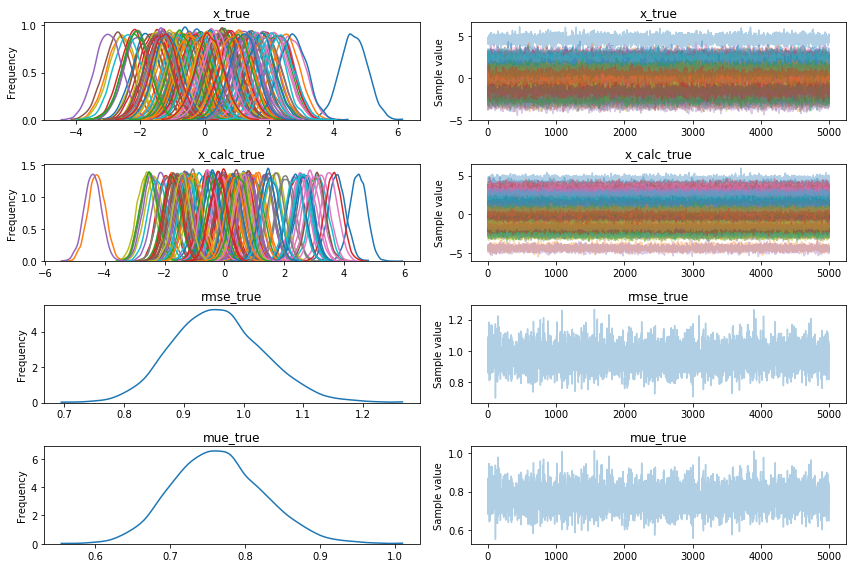

In [15]:
# Plot the posterior confidence interval for RMSE
_ = pm.traceplot(trace)

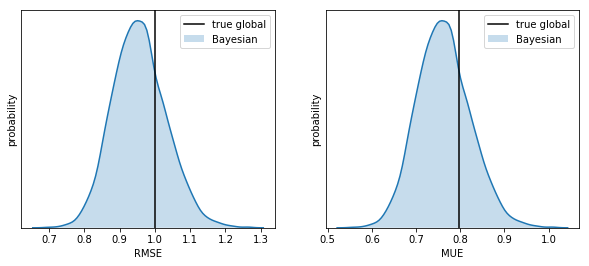

In [16]:
# Plot the Bayesian confidence intervals for the RMSE and MUE
plt.figure(figsize=[10,4]);

# RMSE
plt.subplot(121);
sns.kdeplot(trace['rmse_true'], shade=True);
plt.plot([rmse_true, rmse_true], [0, 10], 'k-');
plt.legend(['true global', 'Bayesian']);
plt.xlabel('RMSE');
plt.ylabel('probability');
plt.yticks([]);

# MUE
plt.subplot(122);
sns.kdeplot(trace['mue_true'], shade=True);
plt.plot([mue_true, mue_true], [0, 10], 'k-');
plt.legend(['true global', 'Bayesian']);
plt.xlabel('MUE');
plt.ylabel('probability');
plt.yticks([]);   

In [17]:
# We can also define a more complex model where more parameters are unknown,
# such as the true distribution parameters

In [18]:
basic_model = pm.Model()

with basic_model:
    # Priors    
    rv_rmse_true = pm.HalfFlat('rmse_true') # uninformative prior for nonnegative values
    rv_mue_true = pm.Deterministic('mue_true', rv_rmse_true*np.sqrt(2.0/np.pi)) # store MUE estimate alongside RMSE
    rv_log_sigma_true = pm.Uniform('log_sigma_true', -2, +2) 
    rv_mu_background = pm.Uniform('mu_background', -2, +2) 
    
    # Unknown true values and true computed values
    rv_true = pm.Normal('x_true', mu=rv_mu_background, sd=np.exp(rv_log_sigma_true), shape=nmeasurements)
    rv_calc_true = pm.Normal('x_calc_true', mu=rv_true, sd=rv_rmse_true, shape=nmeasurements)
    
    # Observation models
    rv_calc = pm.Normal('x_calc', mu=rv_calc_true, sd=sigma_calc, shape=nmeasurements, observed=x_calc)
    rv_exp = pm.Normal('x_exp', mu=rv_true, sd=sigma_exp, shape=nmeasurements, observed=x_exp)

In [19]:
# Find the MAP estimate as a starting point for sampling
map_estimate = pm.find_MAP(model=basic_model)
map_estimate['rmse_true']

logp = -728.91, ||grad|| = 0.13646: 100%|██████████| 101/101 [00:00<00:00, 1238.34it/s] 


array(1.5979764343767784)

In [20]:
# Sample from the posterior and plot the RMSE confidence interval
with basic_model:
    trace = pm.sample(draws=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 5500/5500 [02:59<00:00, 30.70it/s]


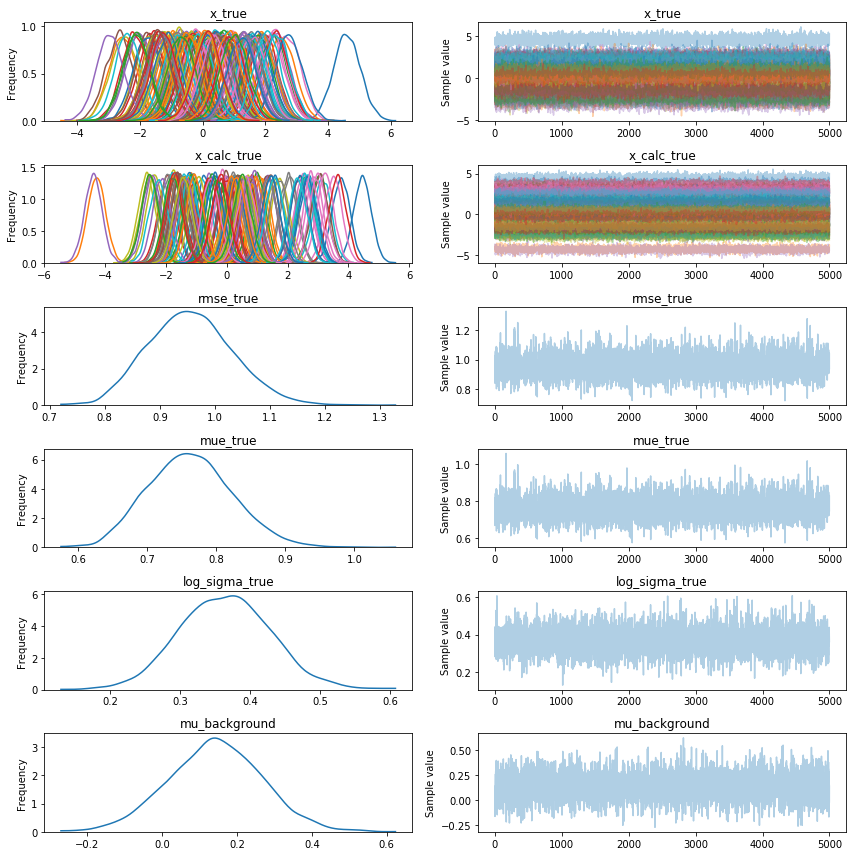

In [21]:
# Plot the posterior confidence interval for RMSE
_ = pm.traceplot(trace)

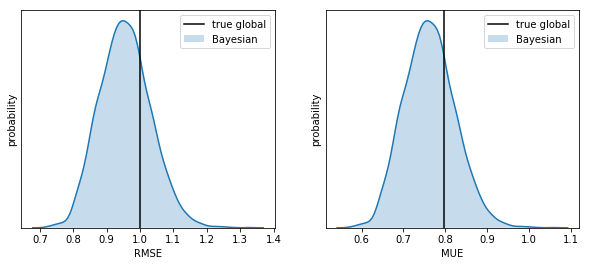

In [22]:
# Plot the Bayesian confidence intervals for the RMSE and MUE
plt.figure(figsize=[10,4]);

# RMSE
plt.subplot(121);
sns.kdeplot(trace['rmse_true'], shade=True);
plt.plot([rmse_true, rmse_true], [0, 10], 'k-');
plt.legend(['true global', 'Bayesian']);
plt.xlabel('RMSE');
plt.ylabel('probability');
plt.yticks([]);

# MUE
plt.subplot(122);
sns.kdeplot(trace['mue_true'], shade=True);
plt.plot([mue_true, mue_true], [0, 10], 'k-');
plt.legend(['true global', 'Bayesian']);
plt.xlabel('MUE');
plt.ylabel('probability');
plt.yticks([]);   

Our Bayesian model accurately captures the a confidence interval about the global RMSE and MUE.